In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch
from collections import defaultdict

from fugw_solver.solver import solver

device = "cpu"

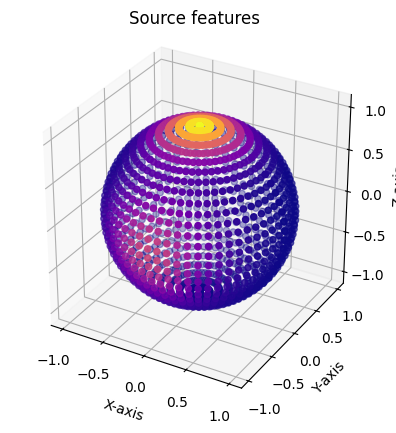

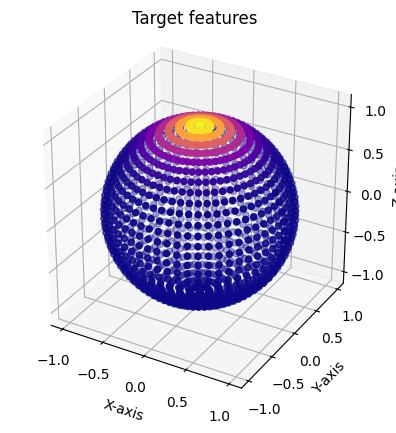

In [57]:
def mises_density(A, mu, kappa=1.0):
    cste = kappa / (4 * np.pi * np.sinh(kappa))
    density = cste * np.exp(kappa * np.dot(A,mu.T))
    return density

def create_sphere(cx, cy, cz, r, resolution=360):
    phi = np.linspace(0, 2*np.pi, 2*resolution)
    theta = np.linspace(0, np.pi, resolution)
    theta, phi = np.meshgrid(theta, phi)
    r_xy = r * np.sin(theta)
    x = cx + np.cos(phi) * r_xy
    y = cy + np.sin(phi) * r_xy
    z = cz + r * np.cos(theta)
    return x, y, z

cx, cy, cz = 0, 0, 0  # Center of the sphere
radius = 1.0
resolution = 30

x, y, z = create_sphere(cx, cy, cz, radius, resolution)

kappa_1 = 5.0  
mu_1 = np.array([0., -1., 0.])
A = np.column_stack((x.flatten(), y.flatten(), z.flatten()))
scalar_values = mises_density(A, mu_1, kappa_1)

kappa_2 = 10.0  
mu_2 = np.array([0., 0., 1.])
target_features = mises_density(A, mu_2, kappa_2)

source_features = target_features + scalar_values

## Source distribution
# Plot the sphere with a color gradient based on scalar values
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=source_features, cmap='plasma', s=20)

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_aspect('equal')
ax.set_title('Source features')

# Add a colorbar to show the density variation
# cbar = plt.colorbar(scatter, ax=ax)
# cbar.set_label('Density')
plt.show()

## Target distribution
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=target_features, cmap='plasma', s=20)

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_aspect('equal')
ax.set_title('Target features')

# cbar = plt.colorbar(scatter, ax=ax)
# cbar.set_label('Density')

plt.show()

In [17]:
source_features_normalized = torch.tensor(source_features, dtype=torch.float32).unsqueeze(0)
target_features_normalized = torch.tensor(target_features, dtype=torch.float32).unsqueeze(0)

# print(source_features_normalized.sum(), target_features_normalized.sum())

source_geometry = torch.tensor(A, dtype=torch.float32)
source_geometry = torch.cdist(source_geometry, source_geometry)
target_geometry = source_geometry

w_s = torch.ones(source_features_normalized.shape[1], device=device) / source_features_normalized.shape[1]
w_t = torch.ones(target_features_normalized.shape[1], device=device) / target_features_normalized.shape[1]

In [41]:
def visualize(alpha, rho, eps, P, source_features, loss_ls, problem):
    print("Total mass transported :", P.sum())
    loss = defaultdict(list)
    for l in loss_ls:
        for k,v in l.items():
            loss[k].append(v)

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.set_title("Mapping training loss")
    ax.set_ylabel("Loss")
    ax.set_xlabel("BCD step")
    ax.stackplot(
        np.arange(len(loss_ls)),
        [
            (1 - alpha) * np.array(loss["wasserstein"]),
            alpha * np.array(loss["gromov_wasserstein"]),
            rho * np.array(loss["marginal_constraint_dim1"]),
            rho * np.array(loss["marginal_constraint_dim2"]),
            eps * np.array(loss["regularization"]),
        ],
        labels=[
            "wasserstein",
            "gromov_wasserstein",
            "marginal_constraint_dim1",
            "marginal_constraint_dim2",
            "regularization",
        ],
        alpha=0.8,
    )
    ax.legend()
    plt.show()
    features_transported = source_features.T * P.sum(axis=1).reshape(-1,1)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(x, y, z, c=features_transported, cmap='plasma', s=20)

    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_aspect('equal')
    ax.set_title(f'transported features for the {problem} problem')

    # cbar = plt.colorbar(scatter, ax=ax)
    # cbar.set_label('Density')

    plt.show()

### Balanced problem

In [5]:
alpha = 0.5
rho_balanced = 100
eps = 1e-4
P_balanced, loss_ls_balanced = solver(alpha=alpha, rho=rho_balanced, eps=eps, 
    source_features=source_features_normalized,
    target_features=target_features_normalized,
    source_geometry=source_geometry,
    target_geometry=target_geometry,
    device=device,
    w_s=w_s,
    w_t=w_t,
    nits_bcd=6
)

Total mass transported : tensor(1.0000)


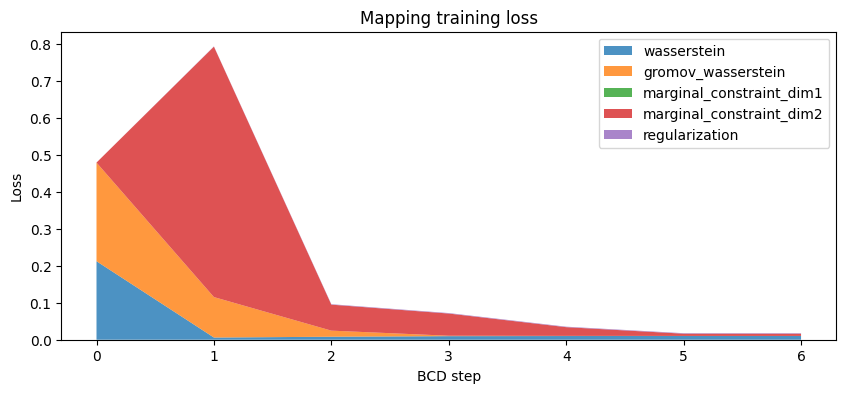

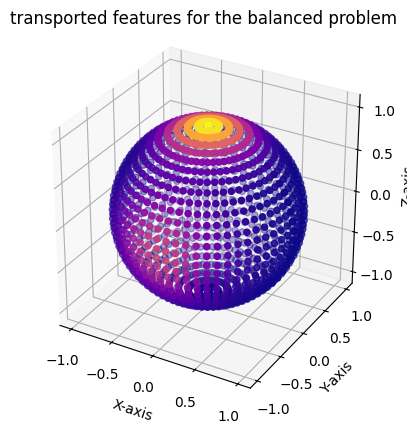

In [42]:
visualize(alpha, rho_balanced, eps, P_balanced, source_features_normalized, loss_ls_balanced, "balanced")

### Unbalanced problem 

In [36]:
alpha = 0.5
rho_unbalanced = 0.1
eps = 1e-4
P_unbalanced, loss_ls_unbalanced = solver(alpha=alpha, rho=rho_unbalanced, eps=eps, 
    source_features=source_features_normalized,
    target_features=target_features_normalized,
    source_geometry=source_geometry,
    target_geometry=target_geometry,
    device=device,
    w_s=w_s,
    w_t=w_t,
    nits_bcd=5
)

Total mass transported : tensor(0.9837)


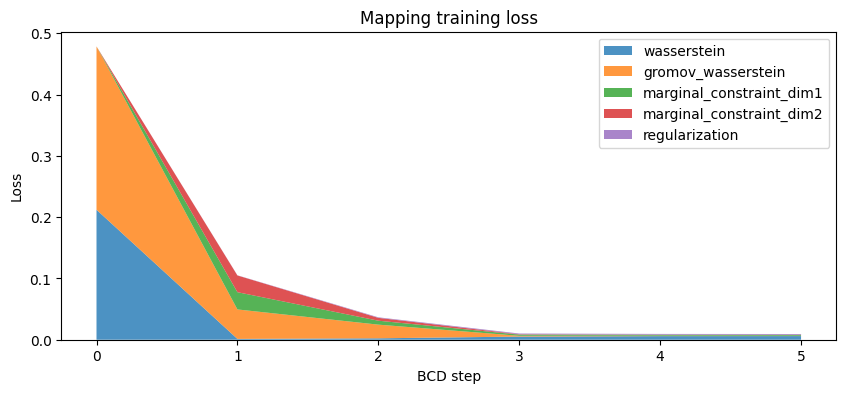

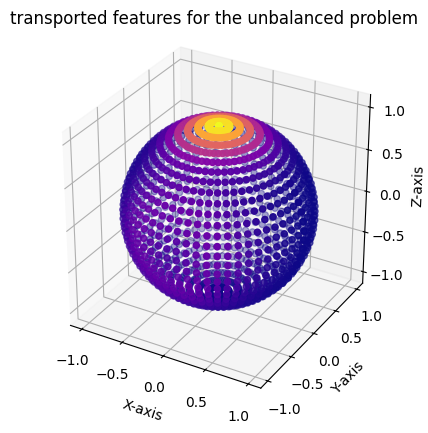

In [43]:
visualize(alpha, rho_unbalanced, eps, P_unbalanced, source_features_normalized, loss_ls_unbalanced, "unbalanced")

tensor(0.0129)

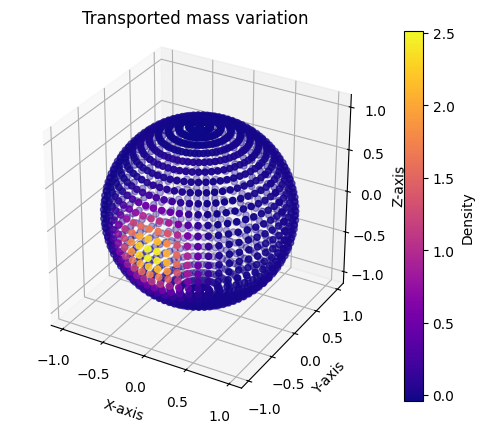

In [56]:
features_transported_balanced = source_features_normalized.T * P_balanced.sum(axis=1).reshape(-1,1)
features_transported_unbalanced = source_features_normalized.T * P_unbalanced.sum(axis=1).reshape(-1,1)

delta_transported = features_transported_balanced - features_transported_unbalanced
delta_transported /= delta_transported.sum() / 100

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=delta_transported, cmap='plasma', s=20)

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_aspect('equal')
ax.set_title(f'Transported mass variation')

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Density')
plt.savefig("figures/mass_variation.png")